# It's a Start

### Imports

In [197]:
import copy
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Fixed realities of the workday

The café is open for 9 hours, say 6:30 to 15:30. Two hours into the day, then starting at circa 08:30, is what one would call a "rush hour". As a baseline, the café gets around 6 customers per hour. During the rush hour, this number can rise to around 30 customers per hour.

In [225]:
HOURS_SIMULATED = 9     # The café is open for 9 hours.
CLOSES = 540            # The simulation ends after those 9 hours and not a minute later.
OPEN_FOR = 525          # They'll stop serving new customers 8.75 hours in, that's 15 minutes before officially closing the shop.
                        # This should give them time to finish any orders they were working on and close up the café.

def arrival_rate(time):
    '''
    Arrival rate in customers per --> minute <--.
    Should peak at around 120 minutes in, that's 08:30.

    arrival_rate(t) = baseline + ( peak * gaussian_bump(t) )
    '''

    baseline    = 6/60      # 6 customers per hour as the baseline.
    peak        = 30/60     # 30 customers per hour at peak hours.
    rush        = 120       # That's 2 hours into the day. 
    rush_length = 60        # Length of rush hour (1 hour).

    return (baseline +   (peak *   (np.exp(-((time-rush)**2) / (2*(rush_length**2))))   )   )

To better visualize this arrival rate, we've prepared a graph.

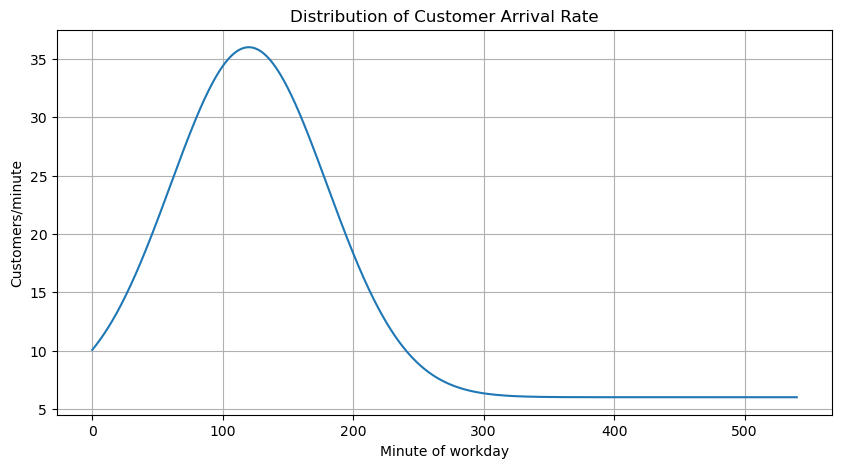

In [ ]:
t = np.linspace(0, 540, 1000)   # 9 hours, 1000 points (smooth).

rate = (arrival_rate(t) * 60) # *60 since the arrival_rate returns the arrival rate in minutes. 

plt.figure(figsize=(10,5))
plt.plot(t, rate)
plt.xlabel("Minute of workday")
plt.ylabel("Customers/minute")
plt.title("Distribution of Customer Arrival Rate")
plt.grid(True)
plt.show()

That's the overarching arrival rate, with the rush hour peaking at around 08:30.

The inter-arrival rate (that is, the distribution of the time between arrivals) is exponential, with $ʎ(t)$ = arrival rate at time $t$, and mean inter-arrival time(t) = $1 / ʎ(t)$.

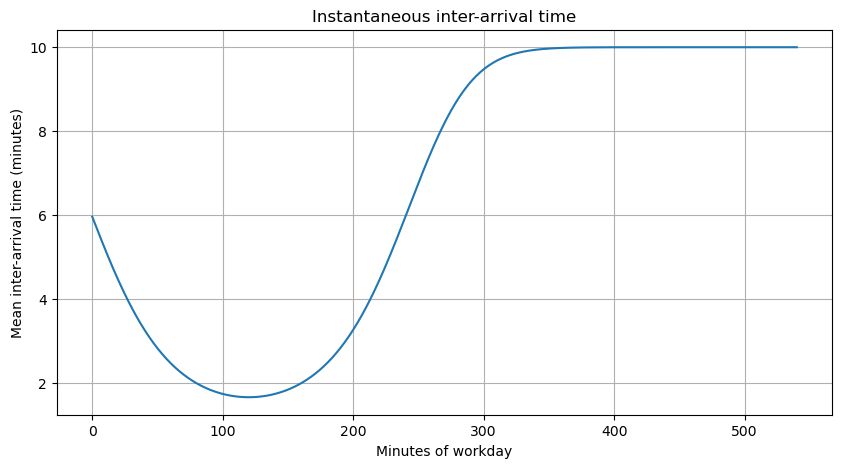

In [236]:
t = np.linspace(0, 540, 1000)
interarrival = 1 / arrival_rate(t)
plt.figure(figsize=(10,5))
plt.plot(t, interarrival)
plt.title("Instantaneous inter-arrival time")
plt.xlabel("Minutes of workday")
plt.ylabel("Mean inter-arrival time (minutes)")
plt.grid(True)
plt.show()

This doesn't illustrate much that hasn't already been illustrated, but shows clearly that circa 10 minutes will pass on average between customers during the baseline (6 customers in 60 minutes) and circa 2 minutes will pass between customer arrivals during the worst of the rush hour.

### Other Global Variables

Notably, we're normalizing everything to SimPy time units = minutes. For the sake of avoiding confusion and ensuring consistency, we will wisely also define seconds, minutes and hours in this context.

* Note that every function that returns a duration should return said value in *minutes*.

Additionally, there are some variables which should be hard-coded in the system. For example, the chance that a coffee machine needs to be utilized in order to complete an order could be something like 90%. In the same vein, the likelihood that an oven needs to be used to complete an order (to heat up a cinnamon bun, or something like that) could be 15%.

The "default variables" for simulations should also be defined here for the sake of good organization. 

The default schedule is:

|           | Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |
| --------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| Registers | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       |
| Baristas  | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       |

This is the café's current schedule, three people on site at all hours. 

The number of machines that their baristas have access to is:

| Coffee Machines | Ovens |
| --------------- | ----- |
| 1               | 1     |

The café owners have also determined that no more than 5 staff members can fit into the same shift, as there is simply not enough space behind the counter. No more than 2 of those can man the registers, as there is not enough physical space to fit more than 2 registers. This means that at maximum a shift could hold either 2 registers and 3 baristas or 1 register and 4 baristas. At minimum, a shift would need at least 1 register and 1 barista as one worker of each kind is needed for the system to function.

In [ ]:
# TIME-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - -  
SECONDS = 1/60
MINUTES = 1
HOURS = 60

# LIKELIHOOD-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - -  
CHANCE_THAT_COFFEE_MACHINE_NEEDED = 0.9
CHANCE_THAT_OVEN_NEEDED = 0.15

# SHIFT-CONSTRAINT-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - 
NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER = 5
NUM_REGISTERS_THAT_FIT = 2

# DEFAULT NUMBER GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - 
DEFAULT_NUM_REGISTERS       = 1
DEFAULT_NUM_BARISTAS        = 2 
DEFAULT_NUM_PICKUP_STATIONS = 1 # TODO: We'll take this out at some point. 
DEFAULT_NUM_COFFEE_MACHINES = 1 
DEFAULT_NUM_OVENS           = 1 

The concept of shifts may now be in your recent memory, as it was previously explained that the default for any shift is to have one person at the register and two persons preparing orders. It's worth elaborating on this concept of shifts, as they are one of the variables we will be playing around with.

The café's schedule is made up of shifts. To simplify things, we will make "shifts" synonymous with "hours". That means that 9 different shifts are available in the day, each an hour long. Like so:

| Hour 1 | Hour 2 | Hour 3 | Hour 4 | Hour 5 | Hour 6 | Hour 7 | Hour 8 | Hour 9 |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |

The number of baristas or registers scheduled to be working can change between shifts, but the aforementioned constraints still apply to each and every one of these shifts.

* We must have at least 1 barista and 1 person at the register scheduled for each shift. This is the minimum amount of staff we need for the system to function.
* No more than 2 people can be at the register on any shift, as only 2 actual registers can fit into the space.
* No mpre than 5 people can be expected to fit behind the counter at once.

In [ ]:

class Shifts:
    def __init__(self, default_num_registers=1, default_num_baristas=1):
        '''
        The default value for each shift is 1 register and 1 barista, 
        the minimum amount of staff needed for the system to function.

        I also added easy-to-use functions to increase or decrease the count of staff in any shift.
        
        shifts.add_register_to_shift(shift=1, count=1)      --> adds 1 register to shift 1.
        shifts.add_register_to_shift(shift=1, count=2)      --> adds 2 registers to shift 1.
        shifts.remove_register_from_shift(shift=1, count=1) --> removes 1 register from shift 1.

        Each time you modify a shift, the shift automatically gets validated according to the constraints we set 
        (no more than 5 people can fit behind the counter and no more than 2 registers can fit in the space).
        If the shift is not valid, the function will return False.
        If it's valid, then it'll return True and you're free to move on.
        '''

        # If the inputs weren't valid, we return an error.
        validate_inputs = [default_num_registers, default_num_baristas]
        if not self.validate_shift(validate_inputs):
            raise ValueError(f"Invalid initial values: registers={default_num_registers} and baristas={default_num_baristas}.")

        # Else, we put this --> {HOURS_SIMULATED} <-- many identical shifts into a list.
        self.shifts = [[default_num_registers, default_num_baristas] for _ in range(HOURS_SIMULATED)]
        
    def _validate_shift(self, shift):

        # Are there at least one register and one barista?
        if ((shift[0] < 1) or (shift[1] < 1)):
            return False
        
        # Are there more than 5 people behind the counter?
        if ((shift[0] + shift[1]) > NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER):
            return False
        
        # Are there more registers here than available? 
        if (shift[0] > NUM_REGISTERS_THAT_FIT):
            return False
        
        return True
    
    def _add_employee_to_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] += count

        if (self.validate_shift(shift)):
            return True
        else:
            shift[employee_type] -= count
            return False
        
    def _remove_employee_from_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] -= count

        if (self.validate_shift(shift)):
            return True
        else:
            shift[employee_type] += count
            return False
        
    def _add_employee_to_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] += count

        # If this was a valid action:
        if (all(self.validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] -= count

        return False
    
    def _remove_employee_from_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] -= count

        # If this was a valid action:
        if (all(self.validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] += count

        return False

    def add_register_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 0)

    def add_barista_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 1)

    def remove_register_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 0)

    def remove_barista_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 1)
    
    def add_register_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 0)

    def add_barista_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 1)
    
    def remove_register_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 0)

    def remove_barista_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 1)



However, when a resource is created with a certain capacity, the capacity cannot be updtaed throughout the run. This makes actually implementing the change in resource capacities between hours kind of tricky. Thus, we will be needing a function to manage these shifts/resources.

In [ ]:
def adjust_staff(role, count, current, pool, hour):
    '''
    shift_manager's helper.
    Adjusts the staff count for the given role at shift change.

    - role:         Str.        "register" or "barista".
    - count:        Int.        Scheduled staff count at this hour.
    - current:      Int.        Current staff count in the shift record
    - pool:         Store.      Pool of staff.
    - hour:         Int.        Current simulation hour.
    '''

    # If we need more staff:
    if (count > current):
        for _ in range(count - current):
            yield pool.put(f"{role}_{hour}")

    # If we need less staff:
    elif (count < current):
        # Note that we're only removing staff that's free. We won't remove someone when they're in the middle of making an order. We'll let them finish.
        remove_count = (current - count)
        for _ in range(remove_count):
            if len(pool.items) > 0:
                yield pool.get()

    # And if the number remains the same, nothing changes.
    else:
        pass


def shift_manager(env, shifts, register_pool, barista_pool, current_shift):
    '''
    Every hour, updating the number of registers and baristas according to schedule.
    
    NOTE: shift.shifts[hour] = [# registers, # baristas]
    '''

    registers_scheduled, baristas_scheduled = shifts.shifts[0]
    current_shift["registers"] = registers_scheduled
    current_shift["baristas"] = baristas_scheduled

    hour = 1
    while (hour < HOURS_SIMULATED):

        yield env.timeout(60) # The shift passes (1 hour, always).

        registers_scheduled, baristas_scheduled = shifts.shifts[hour]

        # - - - - - REGISTERS - - - - -

        yield from adjust_staff(
            role="register",
            count=registers_scheduled,
            current=current_shift["registers"],
            pool=register_pool,
            hour=hour
        )
        current_shift["registers"] = registers_scheduled

        # - - - - - BARISTAS - - - - -

        yield from adjust_staff(
            role="barista",
            count=baristas_scheduled,
            current=current_shift["baristas"],
            pool=barista_pool,
            hour=hour
        )
        current_shift["baristas"] = baristas_scheduled

        # - - - ... and the shift passes. - - - 
        hour += 1 


### Metrics that I'm going to keep track of: a checklist.

1) How long customers have to wait, from when they arrive at the café to when they pick up their order.
    - Would also be nice to see how long customers wait in each "act" (waiting to order + ordering, waiting for their order, picking up their order).  
2) How well all resources are utilized (employees in particular), how much idle time they have.

In [202]:
class Stats:
    '''A class to keep track of the numbers for each simulation.'''

    def __init__(self):
        # CUSTOMER TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []             # Time each custimer spent picking up their order.
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.

        self.arrival_times = []                 # For plotting.

        # OTHER CUSTOMER-RELATED MEASURES
        self.num_customers = 0
        self.avg_length_register_queue = []     # This is a list because we might also want to graph this. Average length of queue per every hour, or something.
        self.avg_length_pickup_queue = []       # I don't think this has ever not been 0. I'm tracking it for the sake of consistency, though.
        self.avg_count_customers_waiting = []   # Could also be cool to graph.

        # TODO: RESOURCE UTILIZATION


### Time distributions defined

*Needs revision

Note that these should all return the time in minutes.

In [203]:
def order_time(rng):
    '''How long it takes a customer to order, in minutes.'''
    
    sample = 10 + rng.gamma(5, 11)      # Shape=5, scale=11, then +10 sec base.
    return min(sample, 120) * SECONDS   # Hard max cutoff: 2 minutes = 120 seconds.

 
def making_order_time(rng):
    '''How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.'''

    # Triangular distribution: min=15s, mode=3min, max=10min.
    return rng.triangular(15, 3*60, 10*60) * SECONDS


# TODO: This will not remain.
# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return max(1, rng.normal(5, 1)) * SECONDS


# Uniform distribution, minimum 0.5 minutes and maximum 2 minutes.
def coffee_machine_time(rng):
    '''How long it takes the barista to use the coffee machine for a given order.'''
    return rng.uniform(low=30, high=120) * SECONDS


# Uniform distribution, minimum 1 minute maximum 5 minutes (just to heat things up).
def oven_time(rng):
    '''How long it takes the barista to use the oven for a given order.'''
    return rng.uniform(low=60, high=300) * SECONDS

### Helpers

In [204]:
def use_coffee_machine(env, ID, coffee_machine, rng):
    '''If a barista needs to use a coffee machine, this function will run.'''

    with (coffee_machine.request() as req):
        yield req
        time = coffee_machine_time(rng)
        print(f"{ID} using coffee machine for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

def use_oven(env, ID, oven, rng):
    '''If a barista needs to use an oven, this function will run.'''

    with (oven.request() as req):
        yield req
        time = oven_time(rng)
        print(f"{ID} using oven for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

In [205]:
def print_stats(statistics):
    '''The stats for each simulation run on a printed format.'''

    print("# Customers:", statistics.num_customers)
    print("Total times in register queue:\n", statistics.register_queue_time)
    print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
    print("Total times in pickup queue:\n", statistics.pickup_queue_time)
    print("Total times in system:\n", statistics.total_time_in_system)
    # *More.

def plot_stats(statistics):
    '''To avoid repeating ourselves.'''

    plt.plot(statistics.total_time_in_system)
    plt.ylabel('Waiting time for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()
    
    plt.plot(statistics.register_queue_time)
    plt.ylabel('Waiting time in register queue for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()
    
    plt.plot(statistics.pickup_queue_time)
    plt.ylabel('Waiting time in pickup queue for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()
    
    plt.plot(statistics.time_until_prep_begins)
    plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
    plt.xlabel('# Customer')
    plt.show()

def plot_arrivals(statistics):
    '''Plots arrivals as a scatter plot + rate histogram.'''

    arrivals = statistics.arrival_times
    
    plt.figure(figsize=(10,4))

    # Scatter plot:
    plt.scatter(arrivals, [0]*len(arrivals), s=10)
    plt.title("Arrivals Scatter Plot")
    plt.xlabel("Time (minutes)")
    plt.yticks([])
    plt.show()

    # Histogram:
    plt.figure(figsize=(10,4))
    plt.hist(arrivals, bins=30)
    plt.xlabel("Time (minutes)")
    plt.ylabel("# Arrivals")
    plt.title("Arrivals Histogram")
    plt.show()

# TODO: Should add plots for resource utilization as well.

### Meatier functions

In [206]:

def customer(env, stats_keeper, ID, register_pool, barista_pool, pickup, coffee_machine, oven, rng, current_shift):
    '''
    Customer's "lifecycle".
    A customer arrives to wait in line, orders + pays, waits while a barista prepares their order, and then pick up their order when it's ready.
    
    Note that the baristas may also use resources such a coffee machine or oven, and the availability of such devices affects the customer's waiting time.
    
    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - ID:               Int.                The customer's ID.
        - register:         Resource.           Staff member who takes your order.
        - barista:          Resource.           Staff member who makes your order.
        - pickup:           Resource.           The spot where you pick up your drink.
        - coffee_machine:   Resource.           The baristas likely need to use it to prepare your order.
        - oven:             Resource.           The baristas may need to use it to prepare your order.
        - rng:              Generator.          A random number generator (RNG).
    '''

    arrival = env.now
    print(f'{ID} arrives at {arrival:.2f}')
    stats_keeper.num_customers += 1

    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    register = yield register_pool.get() # Acuiring staff member.
    
    start_ordering = env.now
    print(f"{ID} begins ordering at {start_ordering:.2f}")
    ordering = order_time(rng)
    yield env.timeout(ordering) # We wait while the customer places their order.
    
    stop_ordering = env.now
    print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # Releasing staff member:
    yield register_pool.put(register)

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    # The barista may need to #
    # use the coffee machine  #
    # and/or oven to complete #
    # the order, and on top   #
    # of that some time gets  #
    # added.                  #
    # # # # # # # # # # # # # # 

    barista = yield barista_pool.get()
    prep_begin = env.now
    print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

    # The time it takes to get an order ready is:
    #
    #       time using coffee machine   Distribution: Uniform
    #   +   time using oven             Distribution: Uniform
    #   +   general prep time           Distribution: Triangle
    #   =   total time                  Distribution: Looks a bit sillier

    needs_coffee =  rng.random() < CHANCE_THAT_COFFEE_MACHINE_NEEDED
    needs_oven =    rng.random() < CHANCE_THAT_OVEN_NEEDED
    
    if (needs_coffee):
        yield env.process(use_coffee_machine(env, ID, coffee_machine, rng))
    if (needs_oven):
        yield env.process(use_oven(env, ID, oven, rng))

    prep_time = making_order_time(rng)
    yield env.timeout(prep_time)

    # - - - - - - - - - - Order finished! - - - - - - - - - -

    time_ready = env.now
    print(f"{ID}'s is ready for pickup at {time_ready:.2f}")

    # The barista then leaves if their shift is over.
    if (len(barista_pool.items) < current_shift["baristas"]):
        yield barista_pool.put(barista)
    else:
        print(f"Barista finishes and goes off shift at {env.now:.2f}")

    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        print(f"{ID} leaves at {end_time:.2f}")

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue  = max(0, (start_ordering - arrival))
    time_in_pickup_queue    = max(0, (time_ready - start_pickup))
    total_time              = max(0, (end_time - arrival))

    stats_keeper.register_queue_time.append(time_in_register_queue)
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = max(0, (time_ready - prep_begin))
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


In [ ]:

def arrivals_generator(env, stats_keeper, register_pool, barista_pool, pickup, coffee_machine, oven, arrival_rate, closing_time, current_shift, seed=None):

    '''
    Generates arrivals of customers according to the chosen arrival_rate.
    Runs the 'customer' process for each of the arrivals.

    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - register:         Resource.           Staff member who takes your order.
        - barista:          Resource.           Staff member who makes your order.
        - pickup:           Resource.           The spot where you pick up your drink.
        - coffee_machine:   Resource.           The baristas likely need to use it to prepare your order.
        - oven:             Resource.           The baristas may need to use it to prepare your order.
        - arrival_rate:     A function.         Returns the "customers per minute" arrival rate based on the the current time.
        - closing_time:     Int.                At which time the staff will stop serving new customers.
        - seed:             int.                Seed for a random number generator.
    '''

    rng = np.random.default_rng(seed)

    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= closing_time):
            print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {closing_time:.2f}.\n")
            return
        
        # TODO: Maybe I should REDEFINE capacity in here??

        rate = arrival_rate(env.now)

        inter_arrival = rng.exponential(1 / rate)       # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)                # Waiting until the next arrival.

        arrival_time = env.now                          # For plotting.
        stats_keeper.arrival_times.append(arrival_time)

        env.process(customer(
            env,
            stats_keeper,
            customer_ID,
            register_pool,
            barista_pool,
            pickup,
            coffee_machine,
            oven,
            rng,
            current_shift
        ))
        customer_ID += 1

I should probably add a short description above each function. Readibility reasons.

In [208]:
def simulate(shifts, num_pickups, num_coffee_machines, num_ovens, arrival_rate, closing_time, ttl):
    '''
    Simulates the process with the specified:
        - num_registers:        Int.    Number of registers / staff at registers.
        - num_baristas:         Int.    Number of baristas (those preparing orders).
        - num_pickups:          Int.    Number of places where drinks can be picked up.
        - num_coffee_machines:  Int.    Number of coffee machines which baristas have at their disposal.
        - num_coffee_ovens:     Int.    Number of ovens which baristas have at their disposal.
        - rates:                Dict.   the customers-per-hour rate for each period of time.
        - closing_time:         Int.    this is when new customers should stop coming in. This is just when we stop taking orders.
        - ttl:                  Float.  "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:           Stats. The numbers for this particular simulation run.
    '''
    
    env = simpy.Environment()
    statistics = Stats()

    #register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
    #barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.

    # < - - - STAFF POOLS - - - >
    # TODO: The number of available resources depends on which shift we're on. (Shift == hour)
    register_pool = simpy.Store(env)
    barista_pool  = simpy.Store(env)
    # So instead of changing the capacity of resources (which isn't possible) we use a store to hold staff objects. We can then add and remove thse objects at shift changes.

    # Initializing shift 1 staff:
    first_shift_num_registers, first_shift_num_baristas = shifts.shifts[0]
    for i in range(first_shift_num_registers):
        register_pool.put(f"register_0")
    for i in range(first_shift_num_baristas):
        barista_pool.put(f"barista_0")

    pickup = simpy.Resource(env, capacity=num_pickups)
    coffee_machine = simpy.Resource(env, capacity=num_coffee_machines)
    oven = simpy.Resource(env, capacity=num_ovens)

    # This is to track the current shift's capacity.
    current_shift = {
        "registers": first_shift_num_registers,
        "baristas": first_shift_num_baristas
    }

    # Starting the shift manager:
    # def shift_manager(env, shifts, register_pool, barista_pool, current_shift)
    env.process(shift_manager(env, shifts, register_pool, barista_pool, current_shift))

    # Starting the arrivals:
    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register_pool=register_pool,
        barista_pool=barista_pool,
        pickup=pickup,
        coffee_machine=coffee_machine,
        oven=oven,
        arrival_rate=arrival_rate,
        closing_time=OPEN_FOR,
        current_shift=current_shift,
        seed=360
    ))
    env.run(until=ttl)

    return statistics


## Default run, default values

In [209]:
#default = simulate(
#    num_registers=DEFAULT_NUM_REGISTERS, 
#    num_baristas=2,
#    num_pickups=1, 
#    num_coffee_machines=2,
#    num_ovens=1,
#    arrival_rate=arrival_rate, 
#    closing_time=OPEN_FOR, 
#    ttl=1000
#    )


default = simulate(
    shifts=Shifts(),
    num_pickups=DEFAULT_NUM_PICKUP_STATIONS, # TODO: This will be removed. 
    num_coffee_machines=DEFAULT_NUM_COFFEE_MACHINES,
    num_ovens=DEFAULT_NUM_OVENS,
    arrival_rate=arrival_rate, 
    closing_time=OPEN_FOR, 
    ttl=CLOSES
)

0 arrives at 1.73
0 begins ordering at 1.73
0 finishes ordering at 2.63
0's order preperation begins at 2.63
0 using coffee machine for 1.08 seconds at 2.63.
1 arrives at 6.26
1 begins ordering at 6.26
0's is ready for pickup at 7.27
0 goes to pick up their order at 7.27
1 finishes ordering at 7.36
1's order preperation begins at 7.36
1 using coffee machine for 0.76 seconds at 7.36.
0 leaves at 7.37
2 arrives at 9.24
2 begins ordering at 9.24
1's is ready for pickup at 9.72
1 goes to pick up their order at 9.72
1 leaves at 9.81
2 finishes ordering at 10.18
2's order preperation begins at 10.18
3 arrives at 12.67
3 begins ordering at 12.67
3 finishes ordering at 13.43
2's is ready for pickup at 14.05
3's order preperation begins at 14.05
2 goes to pick up their order at 14.05
2 leaves at 14.13
3's is ready for pickup at 16.07
3 goes to pick up their order at 16.07
3 leaves at 16.15
4 arrives at 25.64
4 begins ordering at 25.64
4 finishes ordering at 26.76
4's order preperation begins at

#### Stats Display

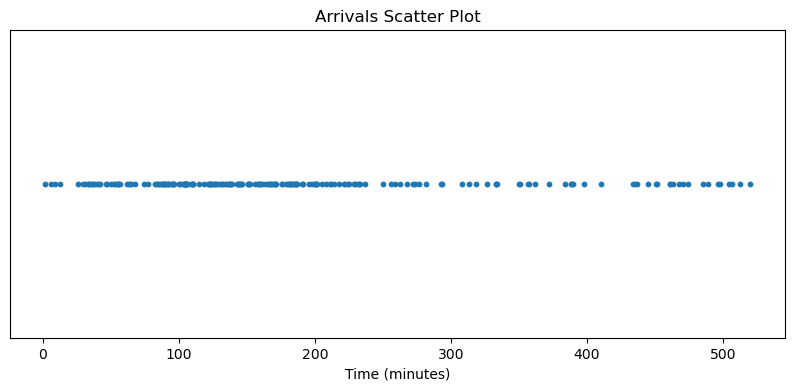

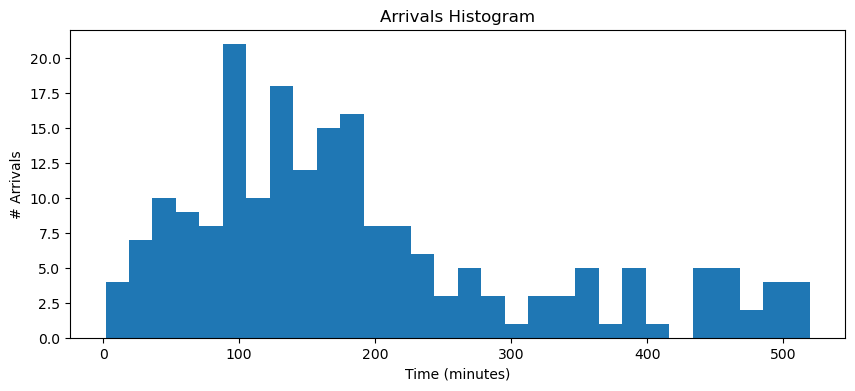

# Customers: 202
Total times in register queue:
 [0, 0, 0, 0, 0, 0, 0, 0, 0.8830396869459705, 2.3950545407037893, 1.535623534273732, 1.717031701190038, 2.555282776450696, 1.0790112028464804, 0, 1.1167919634063708, 0, 0.41858814937616273, 0, 0, 0.36675405896817637, 0.2599114510714742, 1.4031820047421988, 2.2883816492298052, 1.9975379363337282, 0, 0.26417556919987817, 0, 0.39783156861714986, 0, 0, 0, 0, 0, 0, 0.8693270604862846, 0, 0.4083007577744837, 0, 0.4344838313445223, 1.672760498585248, 2.7954916961168124, 1.9033313747968066, 1.8879009607163368, 1.666636505186574, 1.7469404229135392, 1.6046472528713167, 1.7467920049738694, 2.943470425400406, 4.06159822147842, 1.8278853225042297, 1.5865270525484902, 1.2487660773506235, 1.4663527712730229, 1.6942103685235281, 2.7037862043564473, 3.5364281195578826, 4.321264487089465, 4.59264865910761, 4.403346435178577, 4.680534767723543, 2.485698111476964, 2.659472314041153, 3.7467154316622526, 4.442890191214715, 1.9788653621374692, 0, 0, 0.44069242

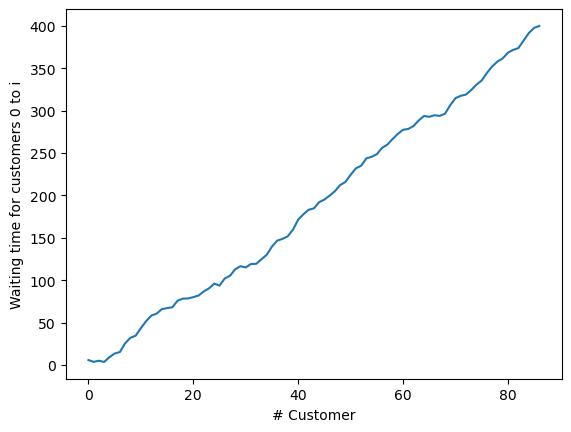

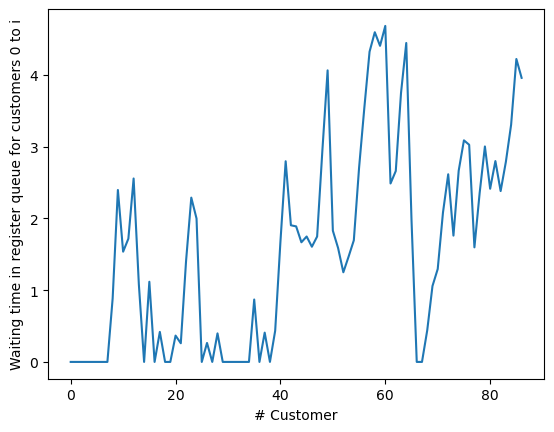

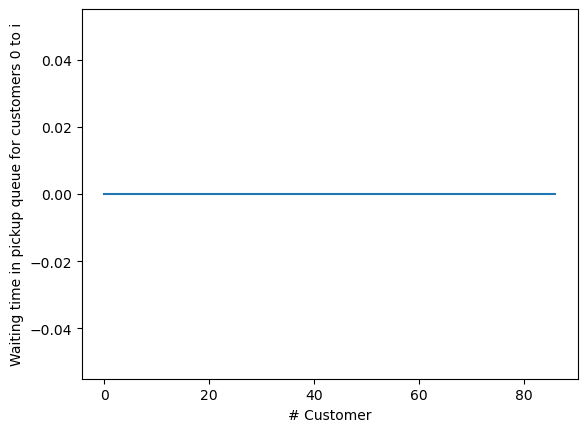

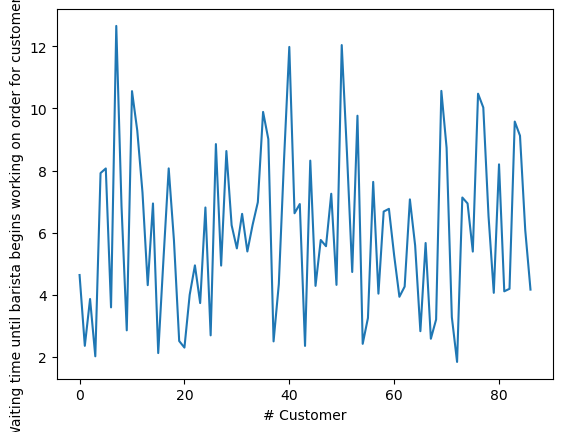

In [210]:
plot_arrivals(default)
print_stats(default)
plot_stats(default)

## Experiments

An experiment can be given on the following format:

In [211]:
class Experiment:
    '''A class  representing a single experiment.'''

    def __init__(self):
        self.num_of_simulations = 1 # One simulation is run by default.
        self.num_registers = DEFAULT_NUM_REGISTERS
        self.num_baristas = DEFAULT_NUM_BARISTAS
        self.num_pickups = DEFAULT_NUM_PICKUP_STATIONS
        self.num_coffee_machines = DEFAULT_NUM_COFFEE_MACHINES
        self.num_ovens = DEFAULT_NUM_OVENS

        # TODO: We'll modify this as we add schedules and such.

List of experiments:

| ID | Description | Justification |
| -- | ----------- | ------------- |
| 1 | One more register on every hour. | Perhaps having two registers always there is the way to go. This means that there are 4 staff members behind the counter at any time. |
| 2 | One more barista on every hour. | Perhaps always having three baristas there is the way to go. This means that there are 4 staff members behind the counter at any time. |
| 3 | One more register during rush hour. | Perhaps having another register open during rush hour is the way to go. This means that there are a total of 4 staff members behind the counter at peak hours, and 3 at other times. |
| 4 | One more barista during rush hour. | Perhaps having another barista working during rush hour is the way to go. This means that there are a total of 4 staff members behind the counter at peak hours, and 3 at other times. | 
| 5 | Two more baristas during rush hour. | Perhaps having another two baristas working during rush hour is the way to go. This means that there are a total of 5 staff members behind the counter at peak hours, and 3 at other times. |
| 6 | ... add more scenarios. | ... |
| 7 | We'll want to experiment with a different amount of staff members in each hour. | And with the number of coffee machines and ovens as well. |
| 8 | Anything I'm forgetting? | ? |


* We'll obviously change this later, I'm just throwing something at the wall.
* Keep in mind what our constraints are:
    * No more than 5 staff members can fit behind the counter.
        * (We can change this constraint if you want, though. If it's too constraining.)
    * No more than 2 registers can fit the space, either.
* The justifications definitely need rephrasing.

Each simulation will be run [UNDECIDED] times.

In [212]:
experiments = {
    0: "Default.",
    1: "One more register on every hour.",
    2: "One more barista on every hour.", 
} # TODO: Do more experiments.

In [213]:
DEFAULT_NUM_SIMULATIONS = 30 # TODO: Change to something else. Or don't.

# Default values:
exp = Experiment()
exp.num_of_simulations    = DEFAULT_NUM_SIMULATIONS
exp.num_registers         = DEFAULT_NUM_REGISTERS
exp.num_baristas          = DEFAULT_NUM_BARISTAS
exp.num_pickups           = DEFAULT_NUM_PICKUP_STATIONS
exp.num_coffee_machines   = DEFAULT_NUM_COFFEE_MACHINES
exp.num_ovens             = DEFAULT_NUM_OVENS

# Initializing each experiment as the default:
exp_1 = copy.deepcopy(exp)
exp_2 = copy.deepcopy(exp)

# Defining the change in each experiment:
exp_1.num_registers         = (DEFAULT_NUM_REGISTERS + 1)       # One more register on every hour.
exp_2.num_baristas          = (DEFAULT_NUM_BARISTAS + 1)        # One more barista on every hour.

experiments_list = [exp, exp_1, exp_2]


### Running Experiments

In [214]:
# nr_experiment = 0
# 
# 
# for experiment in experiments_list:
# 
#     print(f"\n\n\nEXPERIMENT NR. {nr_experiment}:", experiments[nr_experiment], "\n\n")
#     nr_experiment += 1 # For next time.
# 
#     # We'll probably also want to print out the number of the experiment and its title.
# 
#     compiled_stats = [] # Maybe there's a better and less memory-intensive way of compiling these?
# 
#     for i in range(0, experiment.num_of_simulations):
#         run_stats = simulate(
#             num_registers=experiment.num_registers,
#             num_baristas=experiment.num_baristas,
#             num_pickups=experiment.num_pickups,
#             num_coffee_machines=experiment.num_coffee_machines,
#             num_ovens=experiment.num_ovens,
#             arrival_rate=arrival_rate,
#             closing_time=OPEN_FOR,
#             ttl=600 # TODO: We'll want to decide just how long we want the simulation to run after they're no longer taking on new customers.
#         )
# 
#         compiled_stats.append(run_stats)
# 
#         # TODO: I assume we then do something with the stats. Print something, make some graphs
# 

This WAS an idea, but I don't think we can scroll through the amount of text generated. Obviously we could take out a bulk of the print statements, but uhhhhhhhh idk